In [34]:
from numpy.random import seed
seed(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from analysis import *
from collections import namedtuple
import Metrics
from PatientSet import PatientSet
from Constants import Constants
from Clustering import *
import re

#sklearn dependencies
from sklearn.metrics import roc_auc_score, adjusted_rand_score
from sklearn.utils import resample
from sklearn.cluster import FeatureAgglomeration

#we get like a million deprication errors for some reason with the external libraries
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#plotting parameter
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
FIG_SIZE = (20,15)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=FIG_SIZE)

In [35]:
#load in the patientset object that has all the patient info
db = PatientSet()

#add a bunch of features to the object that we'll want to try
#so we can use the db.to_dataframe function to get them all in a nice dataframe with one-hot encoding and labels automatically
db.t_volumes = np.array([np.sum([g.volume for g in gtvs]) for gtvs in db.gtvs]).reshape(-1,1)
db.bilateral = db.lateralities == 'B'
db.total_volumes = db.volumes.sum(axis = 1)
db.toxicity = db.feeding_tubes + db.aspiration > 0
db.tsimdoses = tsim_prediction(db)
db.neck_width = np.linalg.norm(db.centroids[:,Constants.organ_list.index('Lt_Sternocleidomastoid_M'),:] - db.centroids[:,Constants.organ_list.index('Rt_Sternocleidomastoid_M'), :], axis = 1)

/media/andrew/DATA/git_repos/CAMP-RT/PYTHON/Patient.py:360: RuntimeWarning: invalid value encountered in true_divide
  mean_tumor_distances /= tumor_volume
/media/andrew/DATA/git_repos/CAMP-RT/PYTHON/Patient.py:361: RuntimeWarning: invalid value encountered in true_divide
  tumor_position /= tumor_volume


error reading tumor volume for  10091
error reading tumor volume for  10148

patient data loaded...



In [16]:
%load_ext autoreload
%autoreload 2
from Clustering import *

#parameters for the experiments
toxicities_to_test = ['toxicity']

#features to test the feature selection on.  should be fields in the patientset we have
#we don't cluster on these
unclusterable_features = ['t_volumes', 'bilateral', 'total_volumes','neck_width']
#we cluster on these (each individually) if feature_clustering is defined,
clusterable_features = ['tumor_distances', 'volumes']

#features specifically for feature selection vs actually using.  Should either be
#some combo of actual and predicted dose for this
true_features = ['doses']
predicted_features = ['tsimdoses']

#number of times to resample and doing feature selection
#if n = 1, just use the first result
n_samples = 1000

rescale = False
df_rescale = Metrics.normalize

#put some bounds on the features to subset
min_features = 2

#for now just constrain it to one cluster
n_clusters = 2
selection_clusterer  = FClusterer(n_clusters)
cluster_feature_selector = FeatureClusterSelector(
    n_samples = n_samples,
    clusterer = selection_clusterer)
lg_feature_selector = FeatureSelector(n_samples = n_samples)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
true, predicted = get_train_test_datasets(db, 
                                      unclusterable_features, 
                                      clusterable_features, 
                                      true_features, 
                                      predicted_features)

In [18]:
cluster_importances = cluster_feature_selector.get_importances(predicted, db.toxicity, as_df = True)
cluster_importances.describe()

,Esophagus_tsimdoses,Spinal_Cord_tsimdoses,Cricopharyngeal_Muscle_tsimdoses,Cricoid_cartilage_tsimdoses,IPC_tsimdoses,MPC_tsimdoses,Brainstem_tsimdoses,Larynx_tsimdoses,Thyroid_cartilage_tsimdoses,Supraglottic_Larynx_tsimdoses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,0.504963,0.665039,0.929553,8.869972e-01,0.954588,0.871557,7.122625e-01,0.965867,0.969901,0.952232,...,0.631446,0.532647,0.832748,5.774739e-01,0.431933,0.851628,0.226966,0.908714,5.884641e-01,0.259736
std,0.359844,0.342987,0.193462,2.340271e-01,0.124116,0.250250,3.625113e-01,0.092145,0.118047,0.130310,...,0.338199,0.342443,0.263933,4.059736e-01,0.409368,0.211970,0.363742,0.178993,3.831214e-01,0.392088
min,0.000000,0.000000,0.000000,-2.220446e-16,0.000000,0.000000,-2.220446e-16,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-2.220446e-16,0.000000,0.000000,0.000000,0.000000,-2.220446e-16,0.000000
25%,0.208534,0.419357,0.975596,8.550000e-01,0.979595,0.881925,4.422218e-01,0.981608,0.996552,0.974171,...,0.365029,0.195218,0.814214,0.000000e+00,0.000000,0.820000,0.000000,0.913356,1.110223e-16,0.000000
50%,0.525198,0.787028,0.998930,9.958459e-01,0.998025,0.992527,9.130806e-01,0.998694,0.999916,0.997457,...,0.779222,0.575363,0.960994,8.100000e-01,0.393262,0.933410,0.000000,0.985723,7.389950e-01,0.000000
75%,0.856197,0.982596,0.999964,9.999796e-01,0.999892,0.999584,9.982074e-01,0.999952,0.999999,0.999922,...,0.904976,0.851963,0.995450,8.932109e-01,0.865190,0.990604,0.422481,0.998896,9.075668e-01,0.679899
max,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,...,0.999996,0.999779,1.000000,9.999438e-01,1.000000,1.000000,0.999996,1.000000,9.998189e-01,1.000000


In [19]:
lg_importances = lg_feature_selector.get_importances(predicted, db.toxicity, as_df = True)
lg_importances.describe()

,Esophagus_tsimdoses,Spinal_Cord_tsimdoses,Cricopharyngeal_Muscle_tsimdoses,Cricoid_cartilage_tsimdoses,IPC_tsimdoses,MPC_tsimdoses,Brainstem_tsimdoses,Larynx_tsimdoses,Thyroid_cartilage_tsimdoses,Supraglottic_Larynx_tsimdoses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.564797,0.709592,0.693662,0.702919,0.679266,0.724576,0.632550,0.690910,0.679882,0.694700,...,0.504036,0.428888,0.630762,0.285302,0.550482,0.610962,0.543999,0.671620,0.347084,0.596907
std,0.134224,0.076580,0.065484,0.063591,0.062085,0.056054,0.073199,0.056625,0.063970,0.059631,...,0.141715,0.161799,0.076861,0.146609,0.111724,0.066254,0.098888,0.060493,0.202398,0.153019
min,0.000000,0.000000,0.295691,0.471668,0.253906,0.358974,0.004033,0.373816,0.062809,0.256450,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.159085,0.000000,0.101935,0.000000,0.000000
25%,0.535218,0.675200,0.654524,0.662453,0.638798,0.691978,0.591067,0.654995,0.642256,0.659222,...,0.475385,0.380299,0.594409,0.178930,0.515708,0.578531,0.504000,0.636099,0.190396,0.574070
50%,0.592897,0.715895,0.696302,0.706051,0.682355,0.727835,0.638284,0.694950,0.684798,0.697950,...,0.542578,0.475333,0.643426,0.270450,0.568227,0.615654,0.560440,0.674713,0.332032,0.636192
75%,0.640356,0.754119,0.740715,0.746442,0.722091,0.763139,0.681586,0.729307,0.721876,0.737261,...,0.587954,0.537525,0.677533,0.380347,0.613859,0.652838,0.605972,0.710670,0.532346,0.683383
max,0.778862,0.872716,0.857633,0.879722,0.867110,0.900309,0.800725,0.839654,0.839543,0.859559,...,0.747569,0.747328,0.806176,0.704906,0.753736,0.778039,0.734372,0.819271,0.756378,0.801976


In [20]:

top_n_importances = lambda x, n: x.mean().sort_values(ascending = False).iloc[0:n]
def plot_n_importances(x, n):
    x = x.reindex(x.mean().sort_values(ascending=False).index, axis = 'columns')
    x = x.iloc[:,0:n]
    xrange = [x.mean().values.min()*.99, x.mean().values.max()*1.01]
    x.mean().plot.barh(**{'xerr': x.std().values/np.sqrt(n_samples), 'xlim': xrange})

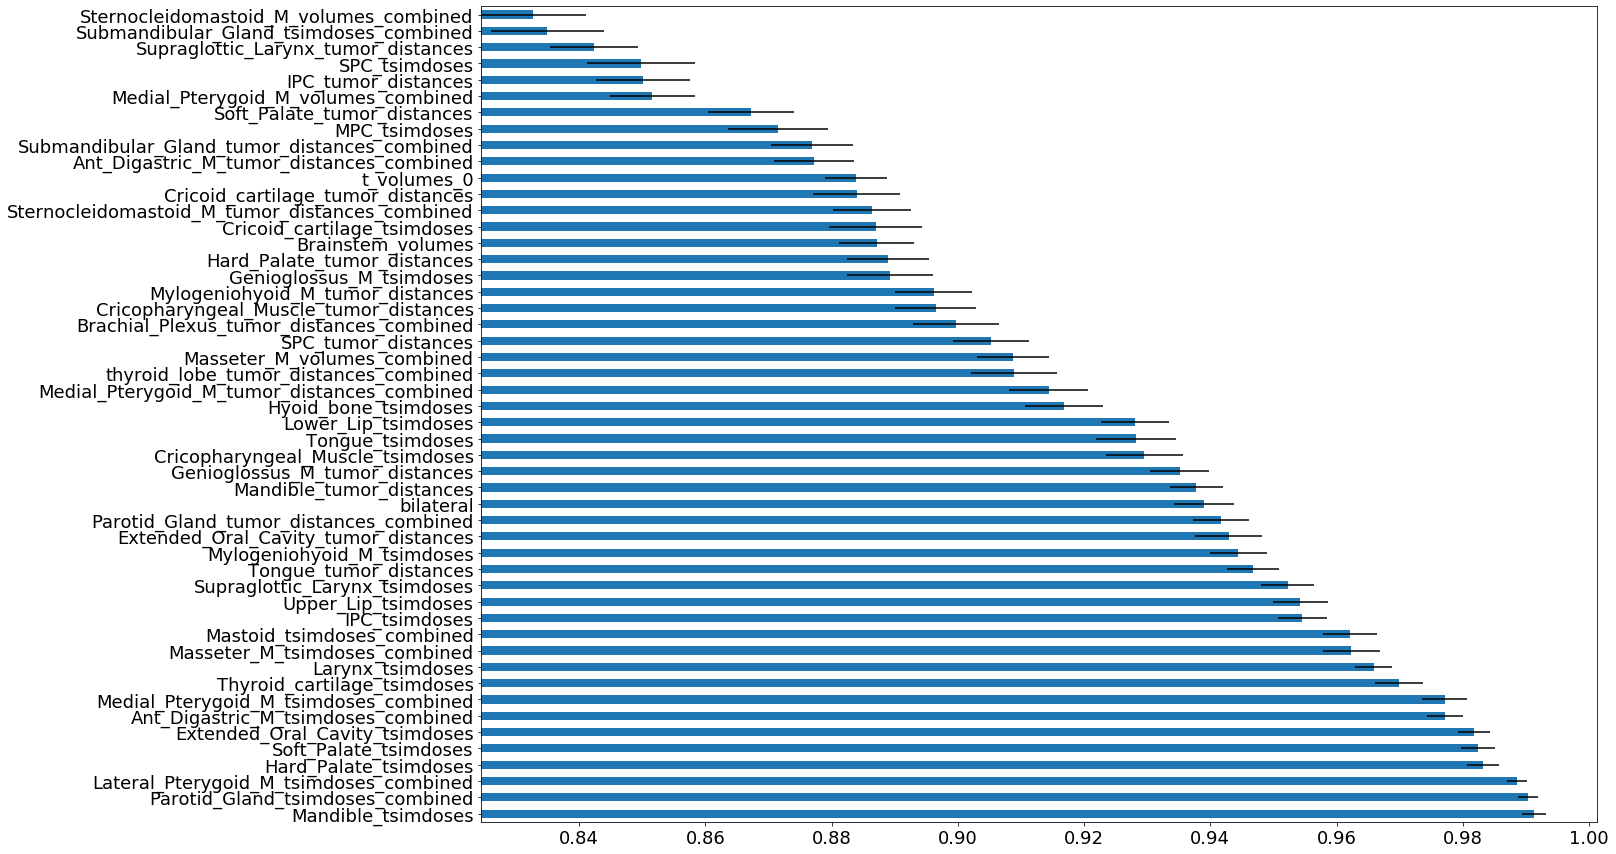

In [21]:
plot_n_importances(cluster_importances, 50)

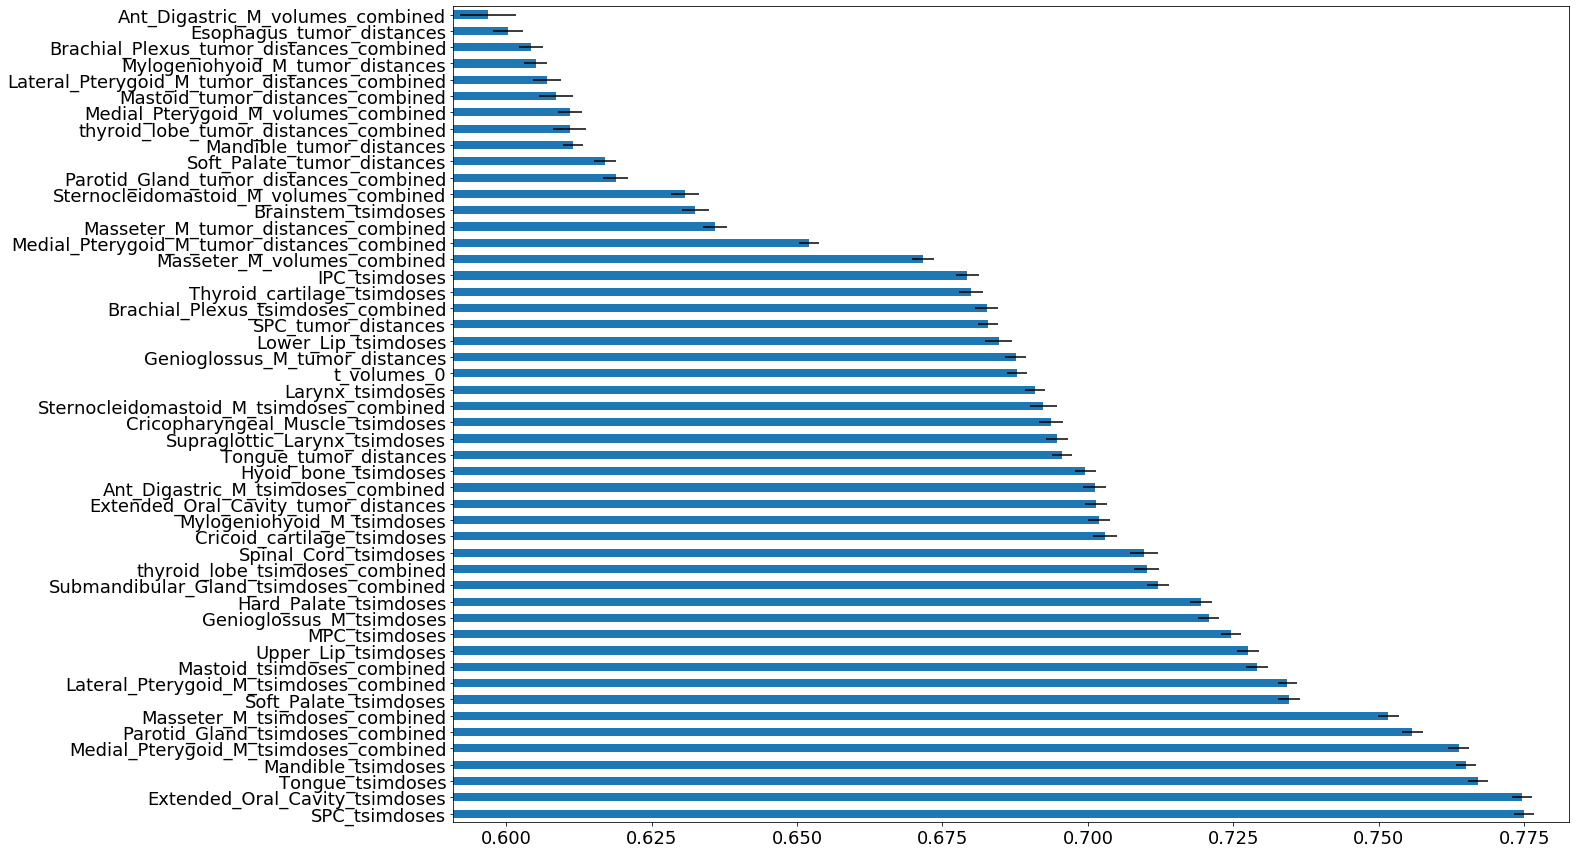

In [22]:
plot_n_importances(lg_importances,50)

In [23]:
true_cluster_importances = cluster_importances = cluster_feature_selector.get_importances(true, db.toxicity, as_df = True)
true_cluster_importances.describe()

,Esophagus_doses,Spinal_Cord_doses,Cricopharyngeal_Muscle_doses,Cricoid_cartilage_doses,IPC_doses,MPC_doses,Brainstem_doses,Larynx_doses,Thyroid_cartilage_doses,Supraglottic_Larynx_doses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03
mean,5.986154e-01,0.563968,7.534099e-01,0.761372,0.869175,0.864437,0.816716,0.888634,0.883446,0.788518,...,0.614024,0.563496,0.857558,5.589400e-01,0.411950,0.831671,2.176692e-01,0.894052,0.606844,2.307672e-01
std,3.338551e-01,0.330927,3.079369e-01,0.311395,0.227101,0.262573,0.265311,0.221313,0.206280,0.397612,...,0.359015,0.330199,0.229457,4.136657e-01,0.410214,0.245343,3.574985e-01,0.197166,0.370707,3.825757e-01
min,-2.220446e-16,0.000000,-2.220446e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-2.220446e-16,0.000000,0.000000,-2.220446e-16,0.000000,0.000000,-2.220446e-16
25%,3.054916e-01,0.296156,5.759023e-01,0.600487,0.861623,0.881849,0.786564,0.909905,0.883601,0.949280,...,0.302371,0.299667,0.825000,0.000000e+00,0.000000,0.810000,0.000000e+00,0.885931,0.369199,0.000000e+00
50%,6.720332e-01,0.612487,9.104516e-01,0.929543,0.972673,0.971282,0.943717,0.991845,0.976941,0.998495,...,0.774864,0.634539,0.972028,8.000000e-01,0.332297,0.946044,0.000000e+00,0.985900,0.730402,0.000000e+00
75%,9.160819e-01,0.871116,9.923559e-01,0.995208,0.997192,0.994681,0.993497,0.999433,0.996832,0.999889,...,0.925718,0.861680,0.996729,8.956142e-01,0.870306,0.988274,4.054477e-01,0.999245,0.907130,6.252513e-01
max,1.000000e+00,0.999629,9.999997e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.999998,0.999920,1.000000,9.999604e-01,0.999998,1.000000,9.999537e-01,1.000000,0.999919,9.999979e-01


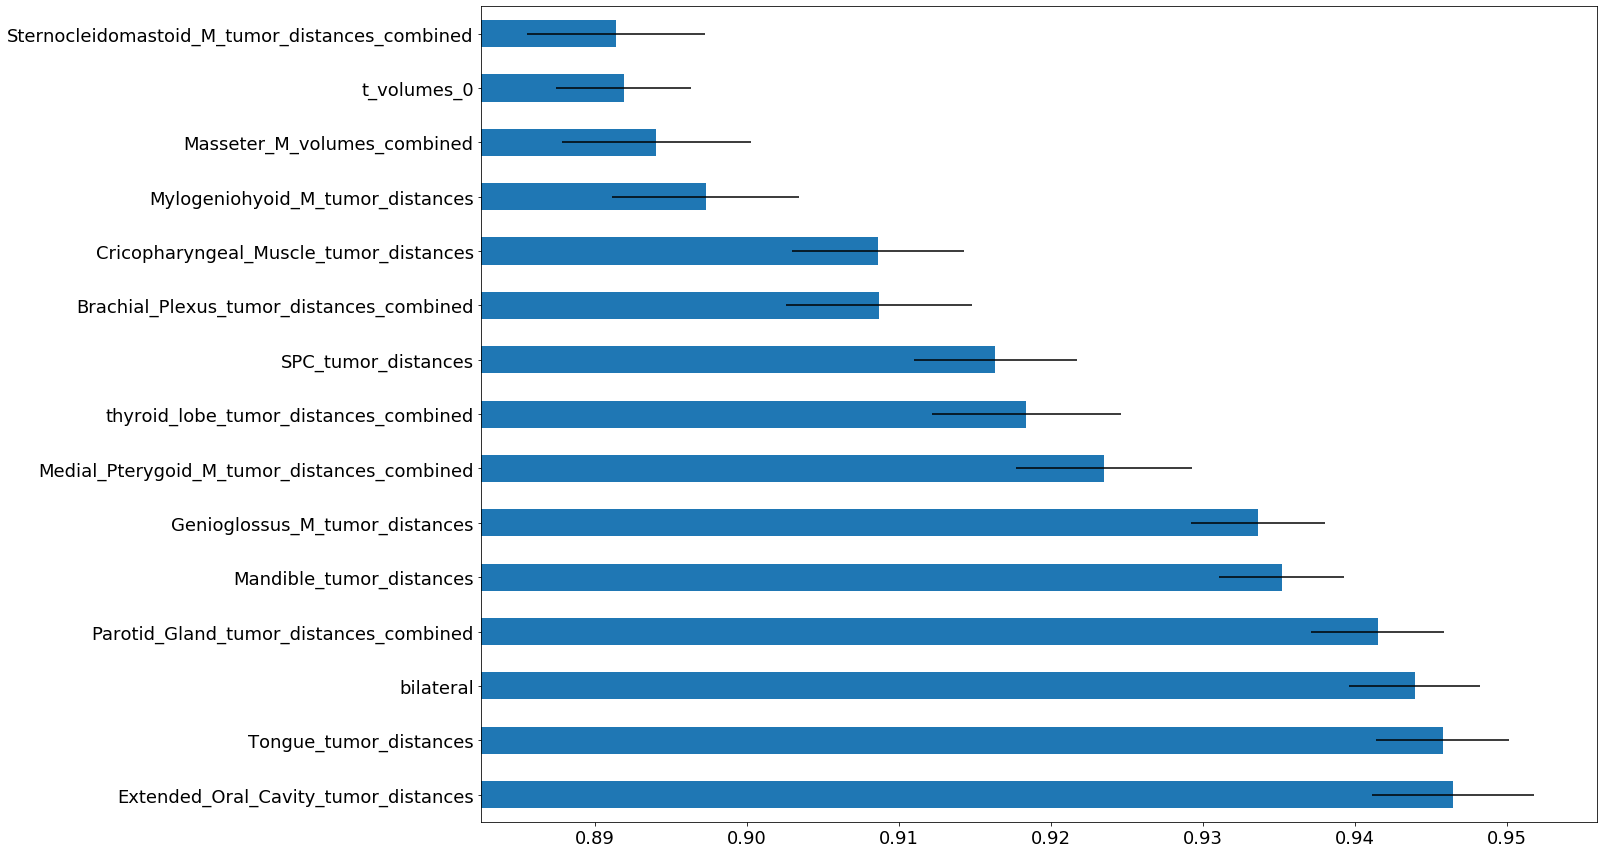

In [24]:
plot_n_importances(true_cluster_importances, 15)

In [25]:
true_lg_importances = cluster_importances = lg_feature_selector.get_importances(true, db.toxicity, as_df = True)
true_lg_importances.describe()

,Esophagus_doses,Spinal_Cord_doses,Cricopharyngeal_Muscle_doses,Cricoid_cartilage_doses,IPC_doses,MPC_doses,Brainstem_doses,Larynx_doses,Thyroid_cartilage_doses,Supraglottic_Larynx_doses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.497272,0.399417,0.498953,0.487815,0.665793,0.667674,0.539446,0.617995,0.617892,0.707711,...,0.502409,0.432141,0.626987,0.283521,0.548482,0.611950,0.545907,0.666313,0.344430,0.594392
std,0.121248,0.163504,0.122853,0.124386,0.056018,0.054389,0.105961,0.071348,0.067822,0.045805,...,0.138362,0.162036,0.073579,0.149311,0.126401,0.075013,0.101719,0.059627,0.206027,0.157114
min,0.000000,0.000000,0.000000,0.000000,0.389653,0.458675,0.000000,0.039548,0.216944,0.535781,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.448055,0.000000,0.000000
25%,0.452885,0.340400,0.461921,0.456052,0.630468,0.631683,0.499978,0.583456,0.580205,0.678278,...,0.474718,0.382503,0.590510,0.169134,0.517622,0.579193,0.504722,0.628534,0.186584,0.570644
50%,0.517820,0.450462,0.520785,0.513607,0.669864,0.667648,0.552760,0.624812,0.621816,0.710042,...,0.535345,0.480683,0.633908,0.275015,0.576909,0.617804,0.562579,0.666434,0.322871,0.634588
75%,0.574531,0.511452,0.572963,0.562578,0.704790,0.707267,0.602508,0.663633,0.664152,0.740227,...,0.585892,0.538897,0.674030,0.394587,0.621585,0.657868,0.609898,0.706590,0.543784,0.682931
max,0.753249,0.658431,0.746320,0.725115,0.809244,0.817275,0.769712,0.807824,0.781126,0.841931,...,0.738064,0.724460,0.802745,0.651665,0.753078,0.820963,0.763381,0.833254,0.762195,0.828052


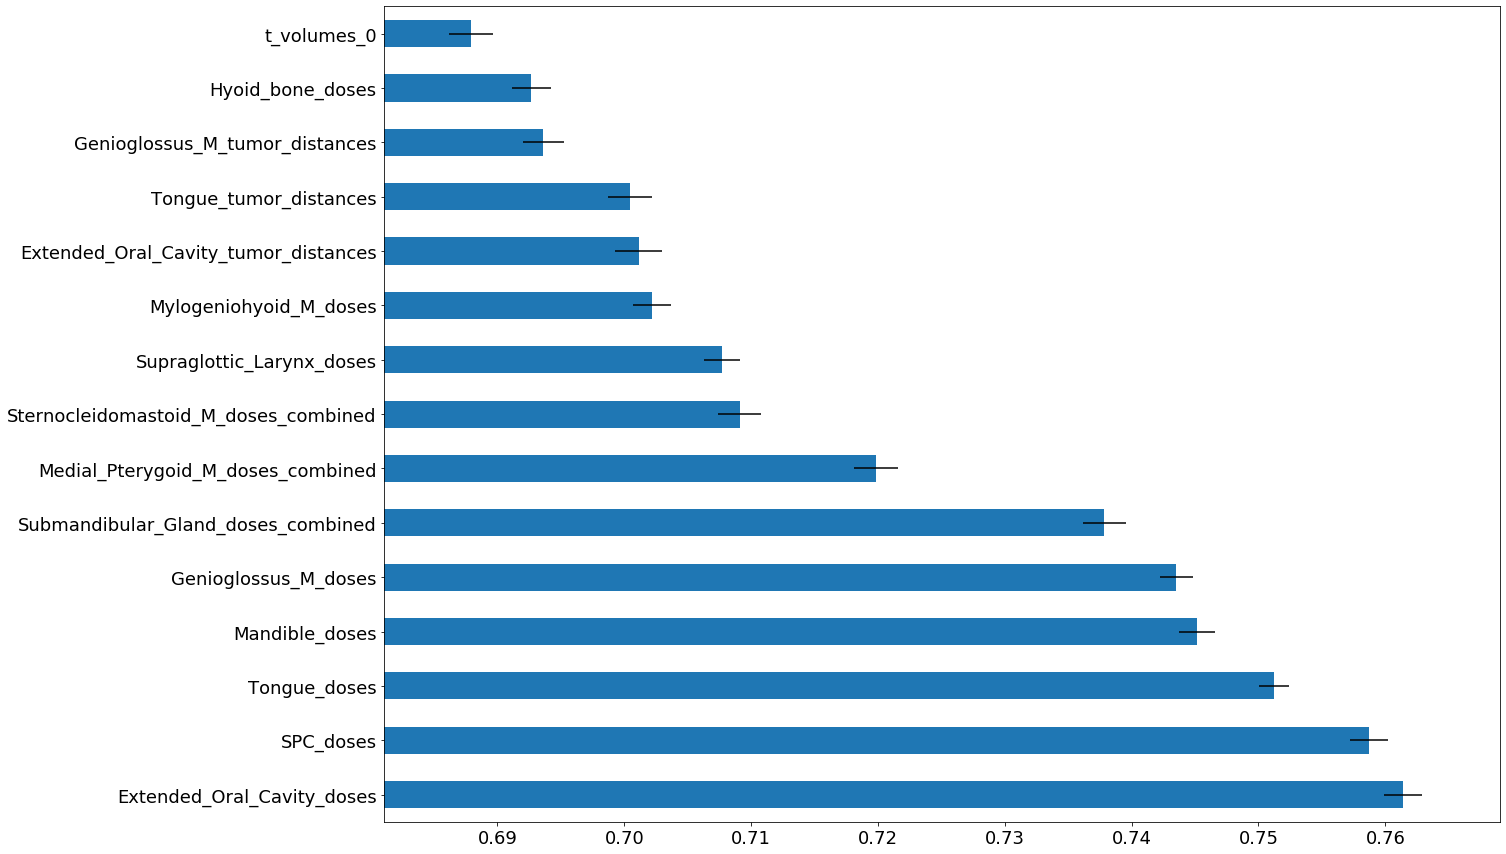

In [26]:
plot_n_importances(true_lg_importances, 15)

In [27]:
cluster_importances

,Esophagus_doses,Spinal_Cord_doses,Cricopharyngeal_Muscle_doses,Cricoid_cartilage_doses,IPC_doses,MPC_doses,Brainstem_doses,Larynx_doses,Thyroid_cartilage_doses,Supraglottic_Larynx_doses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
0,0.520907,0.498937,0.615238,0.441250,0.687656,0.611111,0.394518,0.656920,0.657520,0.758371,...,0.519509,0.457477,0.634125,0.404364,0.605426,0.580836,0.533875,0.612031,0.087446,0.588505
1,0.457125,0.439000,0.528937,0.537031,0.658701,0.588460,0.425525,0.707969,0.689441,0.691406,...,0.566396,0.347305,0.578281,0.218996,0.000000,0.748616,0.705793,0.724009,0.488991,0.675409
2,0.436534,0.515294,0.518072,0.566848,0.614769,0.658523,0.666485,0.613385,0.548177,0.673074,...,0.480352,0.607887,0.691353,0.185541,0.539804,0.603918,0.530826,0.764841,0.314281,0.622392
3,0.503642,0.269140,0.609462,0.519955,0.699329,0.633416,0.601524,0.683281,0.619584,0.726856,...,0.539886,0.519098,0.651884,0.418836,0.637914,0.661957,0.512206,0.673735,0.233168,0.668808
4,0.001949,0.511342,0.039130,0.573693,0.703840,0.623421,0.641460,0.693160,0.644343,0.694767,...,0.395156,0.513007,0.668745,0.261858,0.543124,0.467803,0.416446,0.563008,0.241712,0.695252
5,0.628561,0.000000,0.675986,0.510789,0.569177,0.669872,0.611269,0.657343,0.652344,0.719470,...,0.420467,0.562593,0.621722,0.420681,0.406948,0.614063,0.640469,0.541777,0.000000,0.667781
6,0.666017,0.356883,0.559962,0.590240,0.699970,0.789249,0.585801,0.601706,0.611598,0.578544,...,0.631961,0.341683,0.701079,0.240091,0.600781,0.659200,0.596088,0.681548,0.570826,0.477699
7,0.589394,0.487207,0.367824,0.377059,0.809244,0.645469,0.555502,0.239766,0.631645,0.696615,...,0.306362,0.503340,0.582187,0.544118,0.532747,0.610778,0.609375,0.470659,0.363117,0.718285
8,0.471668,0.378285,0.513458,0.386368,0.705233,0.651145,0.571889,0.645352,0.581857,0.755493,...,0.530320,0.000000,0.524675,0.205161,0.585445,0.627923,0.604451,0.734162,0.619919,0.614640
9,0.632991,0.000000,0.497143,0.422934,0.613095,0.655598,0.511518,0.652960,0.625399,0.715190,...,0.615168,0.637576,0.538015,0.320677,0.506275,0.570695,0.462568,0.769159,0.195490,0.490787


In [15]:
selected_features = pd.read_csv('data/clustering_results/metaClusteringBootstrapped.csv',index_col=0)
cluster_labels = selected_features.cluster_labels
selected_features = selected_features.drop('cluster_labels', axis = 1)
selected_features.head(5)

FileNotFoundError: [Errno 2] File b'data/clustering_results/metaClusteringBootstrapped2.csv' does not exist: b'data/clustering_results/metaClusteringBootstrapped2.csv'

In [ ]:
scorer = FeatureClusterSelector(clusterer = copy(selection_clusterer))
scores = {f: [] for f in selected_features.columns}
scores['baseline'] = []
for n in range(n_samples):
    if n_samples > 1:
        xtemp, ytemp = resample(selected_features, db.toxicity)
    else:
        xtemp, ytemp = selected_features, db.toxicity
    base_score = scorer.bootstrap_score(xtemp, ytemp).mean()
    scores['baseline'].append(base_score)
    for feature in  selected_features.columns:
        xtemp = selected_features.drop(feature, axis = 1)
        new_score = scorer.bootstrap_score(xtemp, db.toxicity).mean()
        scores[feature].append(base_score-new_score)
scores = pd.DataFrame(scores)
scores.describe()

In [ ]:
fscores = scores.drop('baseline', axis = 1).apply(lambda x: 1/np.log(np.abs(1/x))*np.sign(x))
yerr = fscores.std()/np.sqrt(n_samples) if n_samples > 1 else np.zeros((fscores.shape[1],))
yrange = [fscores.mean().values.min()*.9, fscores.mean().values.max()*1.1]
(fscores.mean()).plot.bar(rot = 45, **{'ylim': yrange,'yerr': yerr})

In [ ]:
cluster_importances.Hyoid_bone_doses